In [ ]:
# === 1. Imports ===
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns

# === 2. Load and Prepare Data ===
df = pd.read_csv("final_imputed_data.csv")  # replace with your filename

# === 3. Sort by patient and year, compute next_cogstate ===
df = df.sort_values(by=['PATNO', 'YEAR'])
df['next_cogstate'] = df.groupby('PATNO')['cogstate'].shift(-1)
df['next_age'] = df.groupby('PATNO')['age_at_visit'].shift(-1)

# Drop rows with no next visit
df = df.dropna(subset=['next_cogstate'])

# === 4. Prepare model data ===
features = ['cogstate', 'age_at_visit', 'moca', 'SEX', 'BMI', 'EDUCYRS']
target = 'next_cogstate'

X = df[features].copy()
y = df[target].astype(int).copy()
groups = df['PATNO']

# === 5. Encode categorical (optional if all numeric) ===
X['cogstate'] = X['cogstate'].astype(int)
X['SEX'] = X['SEX'].astype(int)
y = y.astype(int)

# === 6. Define IPW weights ===
ipw_dict = {1: 0.022, 2: 0.101, 3: 0.877}
weights = y.map(ipw_dict)

# === 7. Train/Test Split Grouped by PATNO ===
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
w_train = weights.iloc[train_idx]
w_test  = weights.iloc[test_idx]

# === 8. Fit Multinomial Logistic Regression ===
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
model.fit(X_train, y_train, sample_weight=w_train)

# === 9. Predict on Test Set ===
y_pred = model.predict(X_test)

# === 10. Compute IPW-F1 Score ===
def compute_ipw_f1(y_true, y_pred, weights):
    f1_scores = []
    classes = np.unique(y_true)

    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fp = np.sum((y_pred == cls) & (y_true != cls))
        fn = np.sum((y_pred != cls) & (y_true == cls))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        cls_weight = weights[y_true == cls].mean()
        f1_scores.append(f1 * cls_weight)

    return np.sum(f1_scores)

ipw_f1 = compute_ipw_f1(y_test.values, y_pred, w_test)
print(f"✅ IPW-F1 Score: {ipw_f1:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ IPW-F1 Score: 0.4256


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


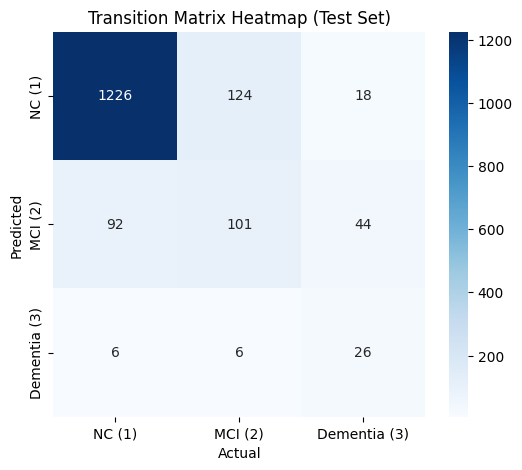

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 2, 3])
cm_df = pd.DataFrame(cm, index=['NC (1)', 'MCI (2)', 'Dementia (3)'],
                         columns=['NC (1)', 'MCI (2)', 'Dementia (3)'])

# Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Transition Matrix Heatmap (Test Set)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()


In [ ]:
# === 1. Imports ===
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === 2. Load and Prepare Data ===
df = pd.read_csv("final_imputed_data.csv")  # replace with actual path

# Sort and calculate next state and age
df = df.sort_values(by=['PATNO', 'YEAR'])
df['next_cogstate'] = df.groupby('PATNO')['cogstate'].shift(-1)
df['next_age'] = df.groupby('PATNO')['age_at_visit'].shift(-1)

df = df.dropna(subset=['next_cogstate'])

# === 3. Prepare features and labels ===
features = ['cogstate', 'age_at_visit', 'moca', 'SEX', 'BMI', 'EDUCYRS']
target = 'next_cogstate'
groups = df['PATNO']

X = df[features].astype(float).copy()
y = df[target].astype(int)
df['sample_weight'] = y.map({1: 0.022, 2: 0.101, 3: 0.877})

# === 4. Define IPW-F1 scorer ===
def compute_ipw_f1(y_true, y_pred, weights):
    f1_scores = []
    classes = np.unique(y_true)

    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fp = np.sum((y_pred == cls) & (y_true != cls))
        fn = np.sum((y_pred != cls) & (y_true == cls))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        cls_weight = weights[y_true == cls].mean()
        f1_scores.append(f1 * cls_weight)

    return np.sum(f1_scores)

# === 5. 5-Fold Grouped Cross-Validation ===
gkf = GroupKFold(n_splits=5)
ipw_f1_scores = []
conf_matrices = []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
    print(f"\n🔁 Fold {fold + 1}")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    w_train = df['sample_weight'].iloc[train_idx]
    w_test  = df['sample_weight'].iloc[test_idx]

    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
    model.fit(X_train, y_train, sample_weight=w_train)

    y_pred = model.predict(X_test)
    ipw_f1 = compute_ipw_f1(y_test.values, y_pred, w_test)
    ipw_f1_scores.append(ipw_f1)

    print(f"✅ IPW-F1: {ipw_f1:.4f}")
    conf_matrices.append(confusion_matrix(y_test, y_pred, labels=[1, 2, 3]))

# === 6. Report Average IPW-F1 ===
avg_ipw_f1 = np.mean(ipw_f1_scores)
print(f"\n📊 Average IPW-F1 over 5 folds: {avg_ipw_f1:.4f}")



🔁 Fold 1


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'mul

✅ IPW-F1: 0.2790

🔁 Fold 2


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ IPW-F1: 0.3262

🔁 Fold 3


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ IPW-F1: 0.3510

🔁 Fold 4


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ IPW-F1: 0.2150

🔁 Fold 5
✅ IPW-F1: 0.4172

📊 Average IPW-F1 over 5 folds: 0.3177


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# optuna